In [1]:
#importing required frameworks and libraries

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is not writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is again writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [4]:
#defining landmarks for each body component
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
#live feed

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        cv2.imshow('LIVE CAM FEED', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            print('Live Feed Terminated')
            break
    cap.release()
    cv2.destroyAllWindows()

Live Feed Terminated


In [272]:
draw_landmarks(frame, results)

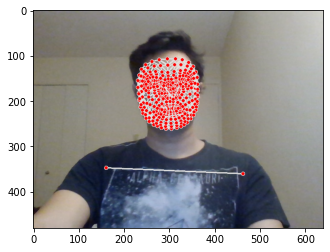

In [273]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [9]:
#DATA COLLECTION

data_path = os.path.join('MP_Data')

# Sign Language Actions used for detection
signs = np.array(['yes', 'no', 'hello', 'thank_you', 'nice_to_meet_you'])

# Data videos for each class and frames in each video
sequence_perclass = 100
sequence_length = 30

In [14]:
#create folders for each class

for sign in signs: 
    for sequence in range(sequence_perclass):
        try: 
            os.makedirs(os.path.join(data_path, sign, str(sequence)))
        except:
            pass

In [15]:
#collections of video sequences for each gesture

start = 0

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for sign in signs:
        for sequence in range(start, start+sequence_perclass):
            for frame_num in range(sequence_length):
                
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_landmarks(image, results)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Class - {}, Sequence Number {}'.format(sign, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Class - {}, Sequence Number {}'.format(sign, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                
                # Export Hollistics Keypoints Data for each frame
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(data_path, sign, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [286]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

label_map = {label:num for num, label in enumerate(signs)}
label_map

{'yes': 0, 'no': 1, 'hello': 2, 'thank_you': 3, 'nice_to_meet_you': 4}

In [287]:
sequences, labels = [], []
for sign in signs:
    for sequence in range(sequence_perclass):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, sign, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[sign])

In [288]:
X = np.array(sequences)

y = to_categorical(labels).astype(int)

In [289]:
y.shape

(500, 5)

In [290]:
#Train/Test/Val Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [291]:
X_train.shape

(350, 30, 1662)

In [292]:
X_val.shape

(75, 30, 1662)

In [293]:
X_test.shape

(75, 30, 1662)

In [10]:
#define LSTM model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

inputs = Input(shape=(30, 1662))
x = LSTM(64, return_sequences=True, activation='relu')(inputs)
x = LSTM(128, return_sequences=True, activation='relu')(x)
x = LSTM(64, return_sequences=False, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
prediction = Dense(signs.shape[0], activation='softmax')(x)

model = Model(inputs=inputs, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 1662)]        0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 64)            442112    
                                                                 
 lstm_4 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 5)                 165   

In [11]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [435]:
es = EarlyStopping(monitor='loss', min_delta = 0.05, mode='min', patience = 30, restore_best_weights=True)

In [436]:
#train LSTM model

import time

start = time.time()

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, callbacks=[es])

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/500
11/11 [==============================] - 4s 191ms/step - loss: 2.8807 - categorical_accuracy: 0.2143 - val_loss: 2.2476 - val_categorical_accuracy: 0.2400
Epoch 2/500
11/11 [==============================] - 2s 166ms/step - loss: 1.8351 - categorical_accuracy: 0.2286 - val_loss: 1.3757 - val_categorical_accuracy: 0.4533
Epoch 3/500
11/11 [==============================] - 2s 154ms/step - loss: 1.5943 - categorical_accuracy: 0.2600 - val_loss: 1.6073 - val_categorical_accuracy: 0.2400
Epoch 4/500
11/11 [==============================] - 2s 155ms/step - loss: 1.5781 - categorical_accuracy: 0.1857 - val_loss: 1.5355 - val_categorical_accuracy: 0.2000
Epoch 5/500
11/11 [==============================] - 2s 155ms/step - loss: 1.4899 - categorical_accuracy: 0.3171 - val_loss: 1.4139 - val_categorical_accuracy: 0.2667
Epoch 6/500
11/11 [==============================] - 2s 154ms/step - loss: 1.4063 - categorical_accuracy: 0.3229 - val_loss: 1.6115 - val_categorical_accuracy: 0.253

Epoch 50/500
11/11 [==============================] - 2s 159ms/step - loss: 0.6912 - categorical_accuracy: 0.6543 - val_loss: 0.7797 - val_categorical_accuracy: 0.4667
Epoch 51/500
11/11 [==============================] - 2s 159ms/step - loss: 0.5770 - categorical_accuracy: 0.7400 - val_loss: 0.5201 - val_categorical_accuracy: 0.7067
Epoch 52/500
11/11 [==============================] - 2s 156ms/step - loss: 0.5134 - categorical_accuracy: 0.7600 - val_loss: 0.5186 - val_categorical_accuracy: 0.6933
Epoch 53/500
11/11 [==============================] - 2s 160ms/step - loss: 0.4796 - categorical_accuracy: 0.7800 - val_loss: 0.5522 - val_categorical_accuracy: 0.7333
Epoch 54/500
11/11 [==============================] - 2s 156ms/step - loss: 0.5829 - categorical_accuracy: 0.7286 - val_loss: 0.7041 - val_categorical_accuracy: 0.6667
Epoch 55/500
11/11 [==============================] - 2s 157ms/step - loss: 0.5121 - categorical_accuracy: 0.7857 - val_loss: 0.4312 - val_categorical_accuracy:

Epoch 99/500
11/11 [==============================] - 2s 154ms/step - loss: 0.0783 - categorical_accuracy: 0.9800 - val_loss: 0.0698 - val_categorical_accuracy: 0.9733
Epoch 100/500
11/11 [==============================] - 2s 153ms/step - loss: 0.0783 - categorical_accuracy: 0.9771 - val_loss: 0.1243 - val_categorical_accuracy: 0.9467
Epoch 101/500
11/11 [==============================] - 2s 154ms/step - loss: 0.1311 - categorical_accuracy: 0.9457 - val_loss: 0.6078 - val_categorical_accuracy: 0.7600
Epoch 102/500
11/11 [==============================] - 2s 154ms/step - loss: 0.3552 - categorical_accuracy: 0.8857 - val_loss: 0.1440 - val_categorical_accuracy: 0.9467
Epoch 103/500
11/11 [==============================] - 2s 154ms/step - loss: 0.2138 - categorical_accuracy: 0.9143 - val_loss: 0.0955 - val_categorical_accuracy: 0.9733
Epoch 104/500
11/11 [==============================] - 2s 154ms/step - loss: 0.1215 - categorical_accuracy: 0.9600 - val_loss: 0.0944 - val_categorical_accu

Train: 0.991, Validation: 0.973


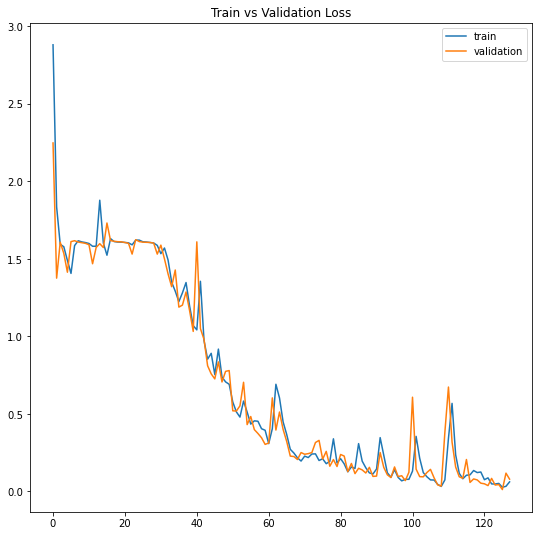

In [503]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))
# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

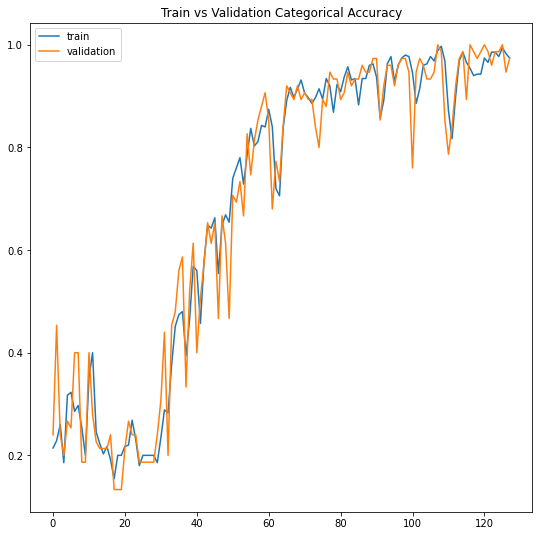

In [438]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='validation')
plt.title('Train vs Validation Categorical Accuracy')
plt.legend()
plt.show()

In [451]:
model.save('lstm_sign_action.h5')

In [12]:
model.load_weights('lstm_sign_action.h5')

In [505]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix

ypred = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
ypred = np.argmax(ypred, axis=1).tolist()

accuracy_score(ytrue, ypred)

0.9866666666666667

In [513]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    #Citiation
    #---------
    #http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

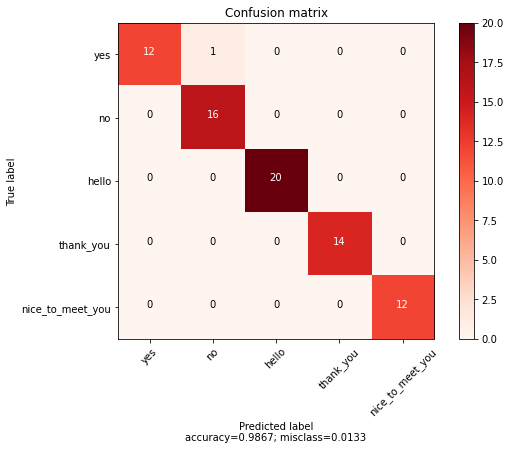

In [514]:
cm = confusion_matrix(ytrue, ypred)

plot_confusion_matrix(cm, signs, cmap='Reds')

# Test in Real Time

In [14]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)

width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

writer= cv2.VideoWriter('livefeed_test.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        draw_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(signs[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold:
                    cv2.putText(image, signs[np.argmax(res)], (0, 45), cv2.FONT_HERSHEY_PLAIN, 1.5, (255,255,255), 1, cv2.LINE_AA)
        writer.write(image)
        cv2.imshow('Live Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    writer.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
thank_you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thank_you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thank_you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thank_you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thank_you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<clas

<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'